### Importing the Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import json # library to handle JSON files
import geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
import seaborn as sns; sns.set_theme()

### Preparing the credentials

In [2]:
CLIENT_ID = 'NY3ZRAH4FQ5VUKNULWWDIZJXQBQTTOOUDA4FXYF2ZO2A4WNO' # your Foursquare ID
CLIENT_SECRET = 'QXLLKB33OEE3QCS0FF5DWRVZDETBGETIABUDBVK4V1ZTK3JM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NY3ZRAH4FQ5VUKNULWWDIZJXQBQTTOOUDA4FXYF2ZO2A4WNO
CLIENT_SECRET:QXLLKB33OEE3QCS0FF5DWRVZDETBGETIABUDBVK4V1ZTK3JM


### Loading the Data

In [3]:
df = pd.read_csv("Bairros.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Bairro  41 non-null     object 
 1   Lat     0 non-null      float64
 2   Long    0 non-null      float64
dtypes: float64(2), object(1)
memory usage: 1.1+ KB


In [5]:
df.head()

,Bairro,Lat,Long
0,Adhemar Garcia,NaN,NaN
1,América,NaN,NaN
2,Anita Garibaldi,NaN,NaN
3,Atiradores,NaN,NaN
4,Aventureiro,NaN,NaN


### Getting the Geographical Coordinates for all my Neighbourhoods

In [6]:
for index, row in df.iterrows():
    #print(row['Bairro'])
    address = row['Bairro'] + ", Joinville Brazil"

    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(address)
    df['Lat'].iloc[index] = location.latitude
    latitude = location.latitude
    df['Long'].iloc[index] = location.longitude
    longitude = location.longitude
#   print(f'The geograpical coordinate of {address} are {latitude}, {longitude}.')
    
#    print(df['Lat'].iloc[index])
#    print(df['Long'].iloc[index])

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
df.head()

,Bairro,Lat,Long
0,Adhemar Garcia,-26.321731,-48.801844
1,América,-26.290361,-48.853581
2,Anita Garibaldi,-26.318420,-48.856278
3,Atiradores,-26.310171,-48.863780
4,Aventureiro,-26.243548,-48.810468


### Creating a Visual Representation from my Data

In [8]:
# create map of New York using latitude and longitude values
map_jlle = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, bairro in zip(df['Lat'], df['Long'], df['Bairro']):
    label = '{}'.format(bairro)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jlle)  
    
map_jlle

### Funtion to connect to Foursquare API and retrieve the Venues Information

In [9]:
def getNearbyVenues(nomes, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for nome, lat, lng in zip(nomes, latitudes, longitudes):
        print(nome)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            nome, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Executing the function

In [10]:
dt_venues = getNearbyVenues(nomes=df['Bairro'],
                                   latitudes=df['Lat'],
                                   longitudes=df['Long']
                                  )

Adhemar Garcia
América
Anita Garibaldi
Atiradores
Aventureiro
Boa Vista
Boehmerwald
Bom Retiro
Bucarein
Centro
Comasa
Costa e Silva
Espinheiros
Fátima
Floresta
Glória
Guanabara
Iririú
Itaum
Itinga
Parque Guarani
Jardim Iririú
Jardim Paraíso
Jarivatuba
Jativoca
João Costa
Morro do Meio
Nova Brasília
Paranaguamirim
Petrópolis
Pirabeiraba
Profipo
Saguaçu
Santa Catarina
Santo Antônio
São Marcos
Ulysses Guimarães
Vila Cubatão
Vila Nova
Zona Industrial Norte
Zona Industrial Tupy


### List of the venues by Neighborhood

In [11]:
print(dt_venues.shape)
dt_venues.head()

(255, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adhemar Garcia,-26.321731,-48.801844,Peto Lanches,-26.318336,-48.803473,Diner
1,Adhemar Garcia,-26.321731,-48.801844,Supermercado Ponto Certo III,-26.322744,-48.799070,Market
2,Adhemar Garcia,-26.321731,-48.801844,Novo Parque São Francisco,-26.321943,-48.805312,Theme Park Ride / Attraction
3,Adhemar Garcia,-26.321731,-48.801844,Parque Natural Municipal da Caieira,-26.322202,-48.805852,Park
4,Adhemar Garcia,-26.321731,-48.801844,restaurante lai lai,-26.325575,-48.803196,Chinese Restaurant


### List of total venues by neighborhood

In [12]:
dt_venues[["Neighborhood","Venue"]].groupby('Neighborhood').count().head()

,Venue
Neighborhood,
Adhemar Garcia,6
América,19
Anita Garibaldi,8
Atiradores,5
Aventureiro,3


In [13]:
print('There are {} uniques categories.'.format(len(dt_venues['Venue Category'].unique())))

There are 95 uniques categories.


### Encoding the categorical features

In [14]:
# one hot encoding
dt_onehot = pd.get_dummies(dt_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dt_onehot['Neighborhood'] = dt_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dt_onehot.columns[-1]] + list(dt_onehot.columns[:-1])
dt_onehot = dt_onehot[fixed_columns]

dt_onehot.head()

,Neighborhood,Accessories Store,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,BBQ Joint,Bakery,Bar,Beer Garden,Big Box Store,Boutique,Bowling Alley,Brazilian Restaurant,Brewery,Burger Joint,Bus Station,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Churrascaria,Clothing Store,Coffee Shop,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Farmers Market,Fast Food Restaurant,Flower Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hospital,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Juice Bar,Light Rail Station,Liquor Store,Lottery Retailer,Market,Martial Arts School,Mediterranean Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Motorcycle Shop,Mountain,Nightclub,Other Great Outdoors,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pub,Recording Studio,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Tea Room,Theme Park Ride / Attraction,Track,Vegetarian / Vegan Restaurant,Warehouse Store,Wine Bar,Women's Store
0,Adhemar Garcia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adhemar Garcia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adhemar Garcia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,Adhemar Garcia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adhemar Garcia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
dt_onehot.shape

(255, 96)

#### Creating a Dataframe containing the Mean Venues/Neighbourhood

In [16]:
dt_grouped = dt_onehot.groupby('Neighborhood').mean().reset_index()
dt_grouped.head()

,Neighborhood,Accessories Store,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,BBQ Joint,Bakery,Bar,Beer Garden,Big Box Store,Boutique,Bowling Alley,Brazilian Restaurant,Brewery,Burger Joint,Bus Station,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Churrascaria,Clothing Store,Coffee Shop,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Farmers Market,Fast Food Restaurant,Flower Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hospital,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Juice Bar,Light Rail Station,Liquor Store,Lottery Retailer,Market,Martial Arts School,Mediterranean Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Motorcycle Shop,Mountain,Nightclub,Other Great Outdoors,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pub,Recording Studio,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Tea Room,Theme Park Ride / Attraction,Track,Vegetarian / Vegan Restaurant,Warehouse Store,Wine Bar,Women's Store
0,Adhemar Garcia,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.000000,0.0,0.000000,0.0,0.000,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.166667,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.000,0.0,0.0,0.000000,0.0
1,América,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.052632,0.0,0.052632,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.000000,0.052632,0.0,0.052632,0.0,0.000,0.052632,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.052632,0.0,0.052632,0.0,0.0,0.052632,0.0,0.052632,0.0,0.0,0.0,0.052632,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.105263,0.052632,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.052632,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.052632,0.0
2,Anita Garibaldi,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.125000,0.0,0.125,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.125000,0.000000,0.0,0.000000,0.0,0.125,0.000000,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.125000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.125,0.0,0.0,0.000000,0.0
3,Atiradores,0.0,0.0,0.0,0.0,0.2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.200,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.2,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.2,0.000,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.2,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.000000,0.0
4,Aventureiro,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.333333,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000,0.333333,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.333333,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,

In [17]:
dt_grouped.describe()

,Accessories Store,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,BBQ Joint,Bakery,Bar,Beer Garden,Big Box Store,Boutique,Bowling Alley,Brazilian Restaurant,Brewery,Burger Joint,Bus Station,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Churrascaria,Clothing Store,Coffee Shop,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Farmers Market,Fast Food Restaurant,Flower Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hospital,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Juice Bar,Light Rail Station,Liquor Store,Lottery Retailer,Market,Martial Arts School,Mediterranean Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Motorcycle Shop,Mountain,Nightclub,Other Great Outdoors,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pub,Recording Studio,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Tea Room,Theme Park Ride / Attraction,Track,Vegetarian / Vegan Restaurant,Warehouse Store,Wine Bar,Women's Store
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.001984,0.006944,0.001263,0.027778,0.018869,0.057780,0.013168,0.002525,0.008207,0.030093,0.002778,0.051062,0.006944,0.032843,0.003968,0.008975,0.002525,0.008617,0.002778,0.002778,0.001984,0.013889,0.015351,0.005556,0.009933,0.006396,0.031823,0.001462,0.010627,0.002725,0.005556,0.003472,0.015792,0.003472,0.001984,0.001984,0.009259,0.003788,0.001984,0.007982,0.018670,0.025820,0.006944,0.001462,0.001984,0.018301,0.028728,0.013889,0.004240,0.001634,0.012862,0.013889,0.001462,0.006746,0.057870,0.001984,0.001263,0.003968,0.001984,0.009259,0.032407,0.002778,0.001634,0.002525,0.007716,0.006171,0.021871,0.046540,0.002525,0.003472,0.005892,0.001263,0.001462,0.024853,0.004762,0.001462,0.010522,0.006944,0.010893,0.004630,0.001263,0.021585,0.029146,0.004630,0.003618,0.005997,0.016204,0.011131,0.010913,0.004630,0.003472,0.001263,0.002525,0.001462,0.001984
std,0.011905,0.041667,0.007576,0.166667,0.056273,0.102379,0.046022,0.015152,0.042136,0.101385,0.016667,0.101804,0.041667,0.075647,0.023810,0.028062,0.015152,0.032133,0.016667,0.016667,0.011905,0.058078,0.083544,0.033333,0.034843,0.022097,0.073405,0.008772,0.036879,0.011425,0.033333,0.020833,0.059125,0.020833,0.011905,0.011905,0.055556,0.016745,0.011905,0.027619,0.041233,0.064706,0.041667,0.008772,0.011905,0.084752,0.077570,0.083333,0.018611,0.009804,0.038594,0.083333,0.008772,0.028670,0.184541,0.011905,0.007576,0.023810,0.011905,0.055556,0.168181,0.016667,0.009804,0.015152,0.032942,0.021959,0.048003,0.115613,0.015152,0.020833,0.028583,0.007576,0.008772,0.068625,0.020203,0.008772,0.055855,0.041667,0.056137,0.027778,0.007576,0.052122,0.100629,0.027778,0.015204,0.025408,0.068485,0.030139,0.047395,0.027778,0.020833,0.00

#### Creating a correlation heatmap.

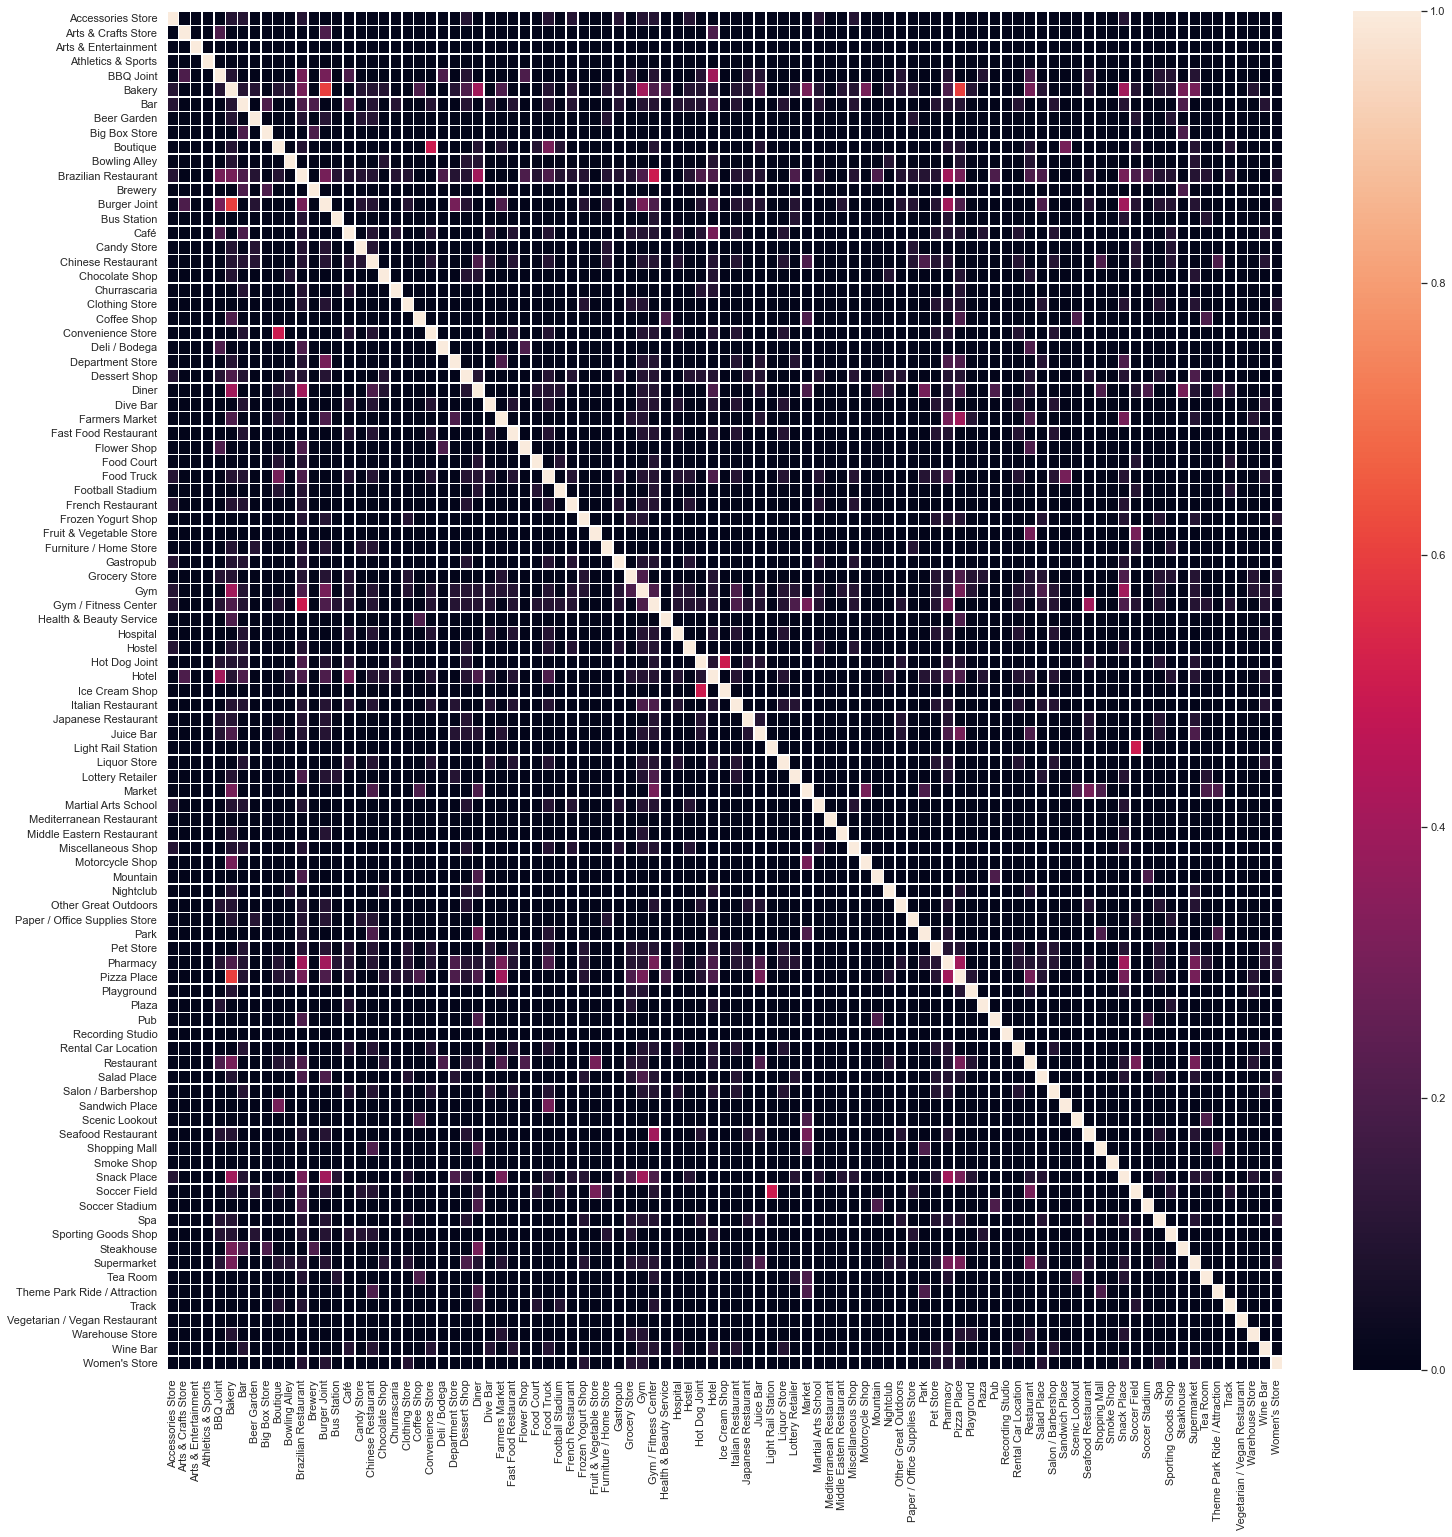

In [89]:
correlacao = dt_grouped.corr(method=histogram_intersection)

fig, ax = plt.subplots(figsize=(25,25))
ax = sns.heatmap(correlacao,linewidths=.5)

corr = np.tril(correlacao)

#### Creating a DataFrame with the 10 most common Venues by neighborhood

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dt_grouped['Neighborhood']

for ind in np.arange(dt_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dt_grouped.iloc[ind, :], num_top_venues)


In [21]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adhemar Garcia,Market,Theme Park Ride / Attraction,Park,Chinese Restaurant,Shopping Mall,Diner,Accessories Store,Other Great Outdoors,Plaza,Playground
1,América,Pet Store,Dive Bar,Hospital,Fast Food Restaurant,Rental Car Location,Salon / Barbershop,Pharmacy,Convenience Store,Gym,Chinese Restaurant
2,Anita Garibaldi,Diner,Food Court,Track,Football Stadium,Boutique,Brazilian Restaurant,Gym / Fitness Center,Soccer Field,Other Great Outdoors,Plaza
3,Atiradores,Restaurant,Deli / Bodega,BBQ Joint,Flower Shop,Brazilian Restaurant,Other Great Outdoors,Pub,Plaza,Playground,Pizza Place
4,Aventureiro,Sandwich Place,Food Truck,Boutique,Accessories Store,Nightclub,Plaza,Playground,Pizza Place,Pharmacy,Pet Store


In [22]:
a = neighborhoods_venues_sorted.describe()
a

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,36,36,36,36,36,36,36,36,36,36,36
unique,36,26,27,23,24,26,23,19,19,18,18
top,Aventureiro,Market,Bakery,Mountain,Plaza,Accessories Store,Plaza,Plaza,Playground,Pharmacy,Pet Store
freq,1,3,6,3,4,4,4,5,6,5,5


## Creating the k-Means and Clustering the Neighborhoods

In [23]:
# set number of clusters
kclusters = 12

dt_grouped_clustering = dt_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dt_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 0, 1, 2, 2, 2, 2])

In [24]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

dt_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
dt_merged = dt_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Bairro')

dt_merged # check the last columns!

,Bairro,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adhemar Garcia,-26.321731,-48.801844,2.0,Market,Theme Park Ride / Attraction,Park,Chinese Restaurant,Shopping Mall,Diner,Accessories Store,Other Great Outdoors,Plaza,Playground
1,América,-26.290361,-48.853581,2.0,Pet Store,Dive Bar,Hospital,Fast Food Restaurant,Rental Car Location,Salon / Barbershop,Pharmacy,Convenience Store,Gym,Chinese Restaurant
2,Anita Garibaldi,-26.318420,-48.856278,2.0,Diner,Food Court,Track,Football Stadium,Boutique,Brazilian Restaurant,Gym / Fitness Center,Soccer Field,Other Great Outdoors,Plaza
3,Atiradores,-26.310171,-48.863780,2.0,Restaurant,Deli / Bodega,BBQ Joint,Flower Shop,Brazilian Restaurant,Other Great Outdoors,Pub,Plaza,Playground,Pizza Place
4,Aventureiro,-26.243548,-48.810468,0.0,Sandwich Place,Food Truck,Boutique,Accessories Store,Nightclub,Plaza,Playground,Pizza Place,Pharmacy,Pet Store
5,Boa Vista,-26.297986,-48.822423,1.0,Burger Joint,Brazilian Restaurant,Department Store,Gym,Gym / Fitness Center,Salad Place,Lottery Retailer,Bakery,Italian Restaurant,Martial Arts School
6,Boehmerwald,-26.363006,-48.828936,2.0,Women's Store,Spa,Pizza Place,Pharmacy,Salad Place,Pet Store,Frozen Yogurt Shop,Clothing Store,Snack Place,Grocery Store
7,Bom Retiro,-26.260933,-48.841919,2.0,Restaurant,Boutique,Pharmacy,Pizza Place,Farmers Market,Supermarket,Juice Bar,Bakery,Theme Park Ride / Attraction,Motorcycle Shop
8,Bucarein,-26.314681,-48.838248,2.0,Juice Bar,Department Store,Pub,Furniture / Home Store,Smoke Shop,Gym / Fitness Center,Pet Store,Café,Restaurant,Supermarket
9,Centro,-26.171192,-50.391000,2.0,Dessert Shop,Supermarket,Diner,Pizza Place,Chocolate Shop,Bowling Alley,Nightclub,Restaurant,Hotel,Bakery


In [25]:
dt_merged = dt_merged.dropna()

#### Converting the Float cluster labels values to Int

In [26]:
dt_merged["Cluster Labels"] = dt_merged["Cluster Labels"].astype(int)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
dt_merged

,Bairro,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adhemar Garcia,-26.321731,-48.801844,2,Market,Theme Park Ride / Attraction,Park,Chinese Restaurant,Shopping Mall,Diner,Accessories Store,Other Great Outdoors,Plaza,Playground
1,América,-26.290361,-48.853581,2,Pet Store,Dive Bar,Hospital,Fast Food Restaurant,Rental Car Location,Salon / Barbershop,Pharmacy,Convenience Store,Gym,Chinese Restaurant
2,Anita Garibaldi,-26.318420,-48.856278,2,Diner,Food Court,Track,Football Stadium,Boutique,Brazilian Restaurant,Gym / Fitness Center,Soccer Field,Other Great Outdoors,Plaza
3,Atiradores,-26.310171,-48.863780,2,Restaurant,Deli / Bodega,BBQ Joint,Flower Shop,Brazilian Restaurant,Other Great Outdoors,Pub,Plaza,Playground,Pizza Place
4,Aventureiro,-26.243548,-48.810468,0,Sandwich Place,Food Truck,Boutique,Accessories Store,Nightclub,Plaza,Playground,Pizza Place,Pharmacy,Pet Store
5,Boa Vista,-26.297986,-48.822423,1,Burger Joint,Brazilian Restaurant,Department Store,Gym,Gym / Fitness Center,Salad Place,Lottery Retailer,Bakery,Italian Restaurant,Martial Arts School
6,Boehmerwald,-26.363006,-48.828936,2,Women's Store,Spa,Pizza Place,Pharmacy,Salad Place,Pet Store,Frozen Yogurt Shop,Clothing Store,Snack Place,Grocery Store
7,Bom Retiro,-26.260933,-48.841919,2,Restaurant,Boutique,Pharmacy,Pizza Place,Farmers Market,Supermarket,Juice Bar,Bakery,Theme Park Ride / Attraction,Motorcycle Shop
8,Bucarein,-26.314681,-48.838248,2,Juice Bar,Department Store,Pub,Furniture / Home Store,Smoke Shop,Gym / Fitness Center,Pet Store,Café,Restaurant,Supermarket
9,Centro,-26.171192,-50.391000,2,Dessert Shop,Supermarket,Diner,Pizza Place,Chocolate Shop,Bowling Alley,Nightclub,Restaurant,Hotel,Bakery


### Creating a Map showing the neighborhoods that are clustered togheter

In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dt_merged['Lat'], dt_merged['Long'], dt_merged['Bairro'], dt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Visualizing a dataframe for each clsuter.

In [29]:
dt_merged.loc[dt_merged['Cluster Labels'] == 0, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Aventureiro,Sandwich Place,Food Truck,Boutique,Accessories Store,Nightclub,Plaza,Playground,Pizza Place,Pharmacy,Pet Store


In [30]:
dt_merged.loc[dt_merged['Cluster Labels'] == 1, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Boa Vista,Burger Joint,Brazilian Restaurant,Department Store,Gym,Gym / Fitness Center,Salad Place,Lottery Retailer,Bakery,Italian Restaurant,Martial Arts School
13,Fátima,Burger Joint,Bakery,Middle Eastern Restaurant,Gym,Snack Place,Nightclub,Plaza,Playground,Pizza Place,Pharmacy
14,Floresta,Burger Joint,Bakery,Pharmacy,Spa,Other Great Outdoors,Gym / Fitness Center,Dessert Shop,Brazilian Restaurant,Supermarket,Hot Dog Joint
17,Iririú,Bakery,Sporting Goods Shop,Chinese Restaurant,Soccer Field,Burger Joint,Paper / Office Supplies Store,Brazilian Restaurant,Furniture / Home Store,Candy Store,Beer Garden
29,Petrópolis,Department Store,Burger Joint,Farmers Market,Pizza Place,Pharmacy,Snack Place,Plaza,Playground,Pet Store,Park


In [31]:
dt_merged.loc[dt_merged['Cluster Labels'] == 2, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adhemar Garcia,Market,Theme Park Ride / Attraction,Park,Chinese Restaurant,Shopping Mall,Diner,Accessories Store,Other Great Outdoors,Plaza,Playground
1,América,Pet Store,Dive Bar,Hospital,Fast Food Restaurant,Rental Car Location,Salon / Barbershop,Pharmacy,Convenience Store,Gym,Chinese Restaurant
2,Anita Garibaldi,Diner,Food Court,Track,Football Stadium,Boutique,Brazilian Restaurant,Gym / Fitness Center,Soccer Field,Other Great Outdoors,Plaza
3,Atiradores,Restaurant,Deli / Bodega,BBQ Joint,Flower Shop,Brazilian Restaurant,Other Great Outdoors,Pub,Plaza,Playground,Pizza Place
6,Boehmerwald,Women's Store,Spa,Pizza Place,Pharmacy,Salad Place,Pet Store,Frozen Yogurt Shop,Clothing Store,Snack Place,Grocery Store
7,Bom Retiro,Restaurant,Boutique,Pharmacy,Pizza Place,Farmers Market,Supermarket,Juice Bar,Bakery,Theme Park Ride / Attraction,Motorcycle Shop
8,Bucarein,Juice Bar,Department Store,Pub,Furniture / Home Store,Smoke Shop,Gym / Fitness Center,Pet Store,Café,Restaurant,Supermarket
9,Centro,Dessert Shop,Supermarket,Diner,Pizza Place,Chocolate Shop,Bowling Alley,Nightclub,Restaurant,Hotel,Bakery
10,Comasa,Diner,Bakery,Steakhouse,Nightclub,Pub,Plaza,Playground,Pizza Place,Pharmacy,Pet Store
11,Costa e Silva,Snack Place,Bakery,Farmers Market,Playground,Warehouse Store,Restaurant,Pizza Place,Gym,Grocery Store,Pharmacy


In [32]:
dt_merged.loc[dt_merged['Cluster Labels'] == 3, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Morro do Meio,Mountain,Accessories Store,Plaza,Playground,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors


In [33]:
dt_merged.loc[dt_merged['Cluster Labels'] == 4, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Jativoca,Soccer Field,Light Rail Station,Accessories Store,Plaza,Playground,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store
31,Profipo,Fruit & Vegetable Store,Soccer Field,Restaurant,Playground,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store,Other Great Outdoors


In [34]:
dt_merged.loc[dt_merged['Cluster Labels'] == 5, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Vila Cubatão,Athletics & Sports,Accessories Store,Mountain,Plaza,Playground,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store


In [35]:
dt_merged.loc[dt_merged['Cluster Labels'] == 6, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Guanabara,Pizza Place,Juice Bar,Diner,Gym,Nightclub,Plaza,Playground,Pharmacy,Pet Store,Park
25,João Costa,Coffee Shop,Bakery,Pizza Place,Health & Beauty Service,Accessories Store,Nightclub,Plaza,Playground,Pharmacy,Pet Store
34,Santo Antônio,Pizza Place,Brazilian Restaurant,Hotel,Hot Dog Joint,Bar,Churrascaria,Café,Accessories Store,Other Great Outdoors,Pub


In [36]:
dt_merged.loc[dt_merged['Cluster Labels'] == 7, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Itaum,Brazilian Restaurant,Mountain,Pub,Soccer Stadium,Diner,Market,Martial Arts School,Light Rail Station,Plaza,Playground
39,Zona Industrial Norte,Brazilian Restaurant,Diner,Hotel,Pharmacy,Food Truck,Park,Other Great Outdoors,Pub,Plaza,Playground


In [37]:
dt_merged.loc[dt_merged['Cluster Labels'] == 8, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Ulysses Guimarães,Ice Cream Shop,Hot Dog Joint,Mountain,Plaza,Playground,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store


In [38]:
dt_merged.loc[dt_merged['Cluster Labels'] == 9, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Nova Brasília,Convenience Store,Boutique,Accessories Store,Nightclub,Pub,Plaza,Playground,Pizza Place,Pharmacy,Pet Store


In [39]:
dt_merged.loc[dt_merged['Cluster Labels'] == 10, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Parque Guarani,Market,Accessories Store,Mountain,Plaza,Playground,Pizza Place,Pharmacy,Pet Store,Park,Paper / Office Supplies Store


In [40]:
dt_merged.loc[dt_merged['Cluster Labels'] == 11, dt_merged.columns[[0] + list(range(4, dt_merged.shape[1]))]]

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Glória,Hotel,Café,Plaza,BBQ Joint,Sporting Goods Shop,Grocery Store,Accessories Store,Playground,Pizza Place,Pharmacy
19,Itinga,Arts & Crafts Store,Hotel,BBQ Joint,Burger Joint,Accessories Store,Nightclub,Plaza,Playground,Pizza Place,Pharmacy


### Importing and Visualizing the Neighborhood Population

In [41]:
pop=pd.read_csv("Populacao.csv")

In [42]:
pop.head()

,Bairro,População
0,Aventureiro,34878
1,Paranaguá-mirim,27728
2,Costa e Silva,27425
3,Jardim-iririú,22756
4,Iririu,22344


<AxesSubplot:xlabel='Bairro'>

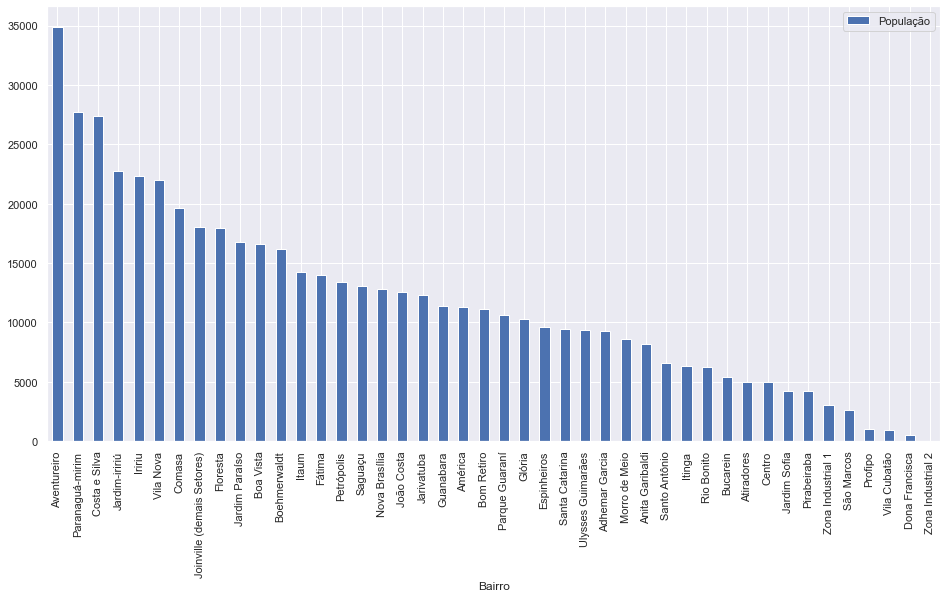

In [43]:
pop.plot(x ='Bairro', y='População', kind="bar", figsize=(16,8))

### Total of the top 10 Venues

In [44]:
dt_merged

,Bairro,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adhemar Garcia,-26.321731,-48.801844,2,Market,Theme Park Ride / Attraction,Park,Chinese Restaurant,Shopping Mall,Diner,Accessories Store,Other Great Outdoors,Plaza,Playground
1,América,-26.290361,-48.853581,2,Pet Store,Dive Bar,Hospital,Fast Food Restaurant,Rental Car Location,Salon / Barbershop,Pharmacy,Convenience Store,Gym,Chinese Restaurant
2,Anita Garibaldi,-26.318420,-48.856278,2,Diner,Food Court,Track,Football Stadium,Boutique,Brazilian Restaurant,Gym / Fitness Center,Soccer Field,Other Great Outdoors,Plaza
3,Atiradores,-26.310171,-48.863780,2,Restaurant,Deli / Bodega,BBQ Joint,Flower Shop,Brazilian Restaurant,Other Great Outdoors,Pub,Plaza,Playground,Pizza Place
4,Aventureiro,-26.243548,-48.810468,0,Sandwich Place,Food Truck,Boutique,Accessories Store,Nightclub,Plaza,Playground,Pizza Place,Pharmacy,Pet Store
5,Boa Vista,-26.297986,-48.822423,1,Burger Joint,Brazilian Restaurant,Department Store,Gym,Gym / Fitness Center,Salad Place,Lottery Retailer,Bakery,Italian Restaurant,Martial Arts School
6,Boehmerwald,-26.363006,-48.828936,2,Women's Store,Spa,Pizza Place,Pharmacy,Salad Place,Pet Store,Frozen Yogurt Shop,Clothing Store,Snack Place,Grocery Store
7,Bom Retiro,-26.260933,-48.841919,2,Restaurant,Boutique,Pharmacy,Pizza Place,Farmers Market,Supermarket,Juice Bar,Bakery,Theme Park Ride / Attraction,Motorcycle Shop
8,Bucarein,-26.314681,-48.838248,2,Juice Bar,Department Store,Pub,Furniture / Home Store,Smoke Shop,Gym / Fitness Center,Pet Store,Café,Restaurant,Supermarket
9,Centro,-26.171192,-50.391000,2,Dessert Shop,Supermarket,Diner,Pizza Place,Chocolate Shop,Bowling Alley,Nightclub,Restaurant,Hotel,Bakery


In [45]:
palavras = []
for index, row in dt_merged.iterrows():
    palavras.append(row['1st Most Common Venue'])
    palavras.append(row['2nd Most Common Venue'])
    palavras.append(row["3rd Most Common Venue"])
    palavras.append(row["4th Most Common Venue"])
    palavras.append(row["5th Most Common Venue"])
    palavras.append(row["6th Most Common Venue"])
    palavras.append(row["7th Most Common Venue"])
    palavras.append(row["8th Most Common Venue"])
    palavras.append(row["9th Most Common Venue"])
    palavras.append(row["10th Most Common Venue"])

In [46]:
df_venues_count = pd.DataFrame(palavras)

In [47]:
df_venues_count = pd.DataFrame(df_venues_count.value_counts())

<AxesSubplot:xlabel='0'>

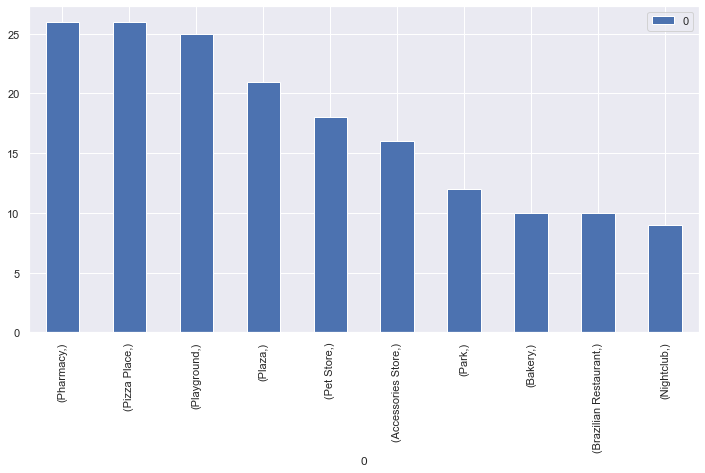

In [48]:
top_10_venues = df_venues_count.head(10)
top_10_venues.plot(kind="bar", figsize=(12,6))

In [52]:
dt_merged.shape

(36, 14)

## Venues per Cluester

#### Cluster 0

<AxesSubplot:xlabel='0'>

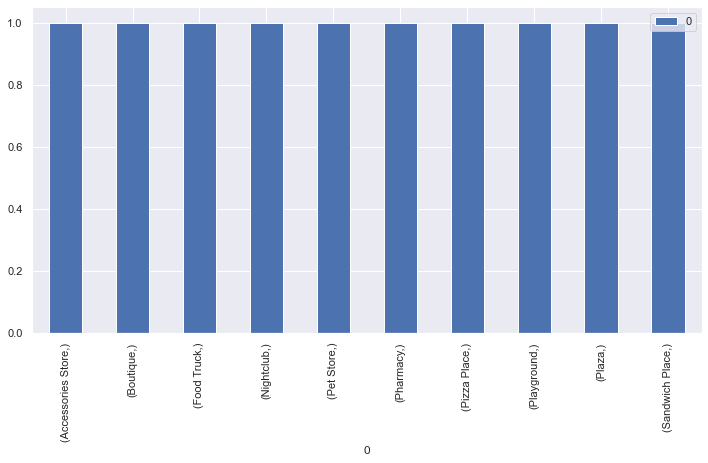

In [91]:
palavras_cluster0 = []
for index, row in dt_merged[dt_merged["Cluster Labels"]==0].iterrows():
    palavras_cluster0.append(row['1st Most Common Venue'])
    palavras_cluster0.append(row['2nd Most Common Venue'])
    palavras_cluster0.append(row["3rd Most Common Venue"])
    palavras_cluster0.append(row["4th Most Common Venue"])
    palavras_cluster0.append(row["5th Most Common Venue"])
    palavras_cluster0.append(row["6th Most Common Venue"])
    palavras_cluster0.append(row["7th Most Common Venue"])
    palavras_cluster0.append(row["8th Most Common Venue"])
    palavras_cluster0.append(row["9th Most Common Venue"])
    palavras_cluster0.append(row["10th Most Common Venue"])
    
df_venues_count_cluster0 = pd.DataFrame(palavras_cluster0)
df_venues_count_cluster0 = pd.DataFrame(df_venues_count_cluster0.value_counts())

top_10_venues_cluster0 = df_venues_count_cluster0.head(10)
top_10_venues_cluster0.plot(kind="bar", figsize=(12,6))

Cluster 1

<AxesSubplot:xlabel='0'>

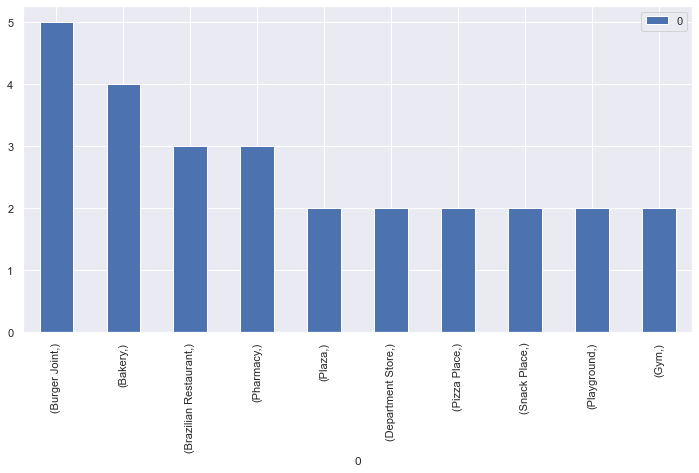

In [73]:
palavras_cluster1 = []
for index, row in dt_merged[dt_merged["Cluster Labels"]==1].iterrows():
    palavras_cluster1.append(row['1st Most Common Venue'])
    palavras_cluster1.append(row['2nd Most Common Venue'])
    palavras_cluster1.append(row["3rd Most Common Venue"])
    palavras_cluster1.append(row["4th Most Common Venue"])
    palavras_cluster1.append(row["5th Most Common Venue"])
    palavras_cluster1.append(row["6th Most Common Venue"])
    palavras_cluster1.append(row["7th Most Common Venue"])
    palavras_cluster1.append(row["8th Most Common Venue"])
    palavras_cluster1.append(row["9th Most Common Venue"])
    palavras_cluster1.append(row["10th Most Common Venue"])
    
df_venues_count_cluster1 = pd.DataFrame(palavras_cluster1)
df_venues_count_cluster1 = pd.DataFrame(df_venues_count_cluster1.value_counts())

top_10_venues_cluster1 = df_venues_count_cluster1.head(10)
top_10_venues_cluster1.plot(kind="bar", figsize=(12,6))

Cluster 2

<AxesSubplot:xlabel='0'>

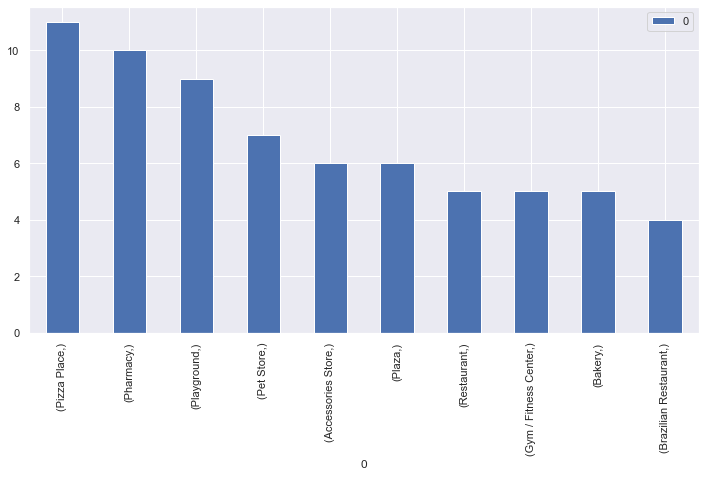

In [74]:
palavras_cluster2 = []
for index, row in dt_merged[dt_merged["Cluster Labels"]==2].iterrows():
    palavras_cluster2.append(row['1st Most Common Venue'])
    palavras_cluster2.append(row['2nd Most Common Venue'])
    palavras_cluster2.append(row["3rd Most Common Venue"])
    palavras_cluster2.append(row["4th Most Common Venue"])
    palavras_cluster2.append(row["5th Most Common Venue"])
    palavras_cluster2.append(row["6th Most Common Venue"])
    palavras_cluster2.append(row["7th Most Common Venue"])
    palavras_cluster2.append(row["8th Most Common Venue"])
    palavras_cluster2.append(row["9th Most Common Venue"])
    palavras_cluster2.append(row["10th Most Common Venue"])
    
df_venues_count_cluster2 = pd.DataFrame(palavras_cluster2)
df_venues_count_cluster2 = pd.DataFrame(df_venues_count_cluster2.value_counts())

top_10_venues_cluster2 = df_venues_count_cluster2.head(10)
top_10_venues_cluster2.plot(kind="bar", figsize=(12,6))

Clsuter 3

<AxesSubplot:xlabel='0'>

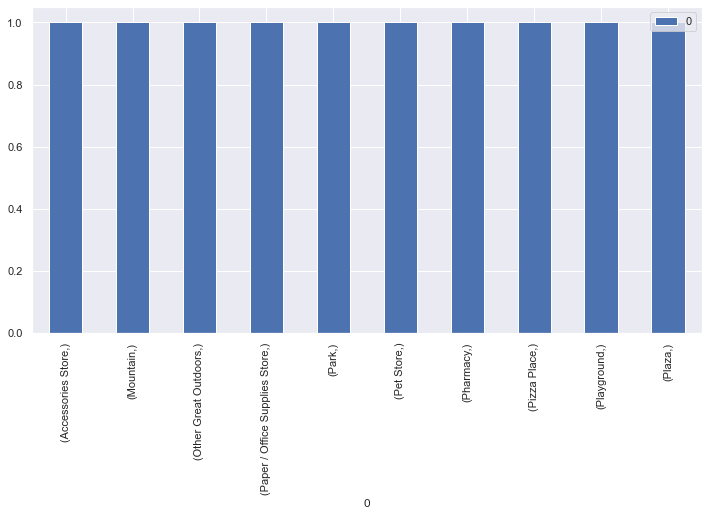

In [76]:
palavras_cluster3 = []
for index, row in dt_merged[dt_merged["Cluster Labels"]==3].iterrows():
    palavras_cluster3.append(row['1st Most Common Venue'])
    palavras_cluster3.append(row['2nd Most Common Venue'])
    palavras_cluster3.append(row["3rd Most Common Venue"])
    palavras_cluster3.append(row["4th Most Common Venue"])
    palavras_cluster3.append(row["5th Most Common Venue"])
    palavras_cluster3.append(row["6th Most Common Venue"])
    palavras_cluster3.append(row["7th Most Common Venue"])
    palavras_cluster3.append(row["8th Most Common Venue"])
    palavras_cluster3.append(row["9th Most Common Venue"])
    palavras_cluster3.append(row["10th Most Common Venue"])
    
df_venues_count_cluster3 = pd.DataFrame(palavras_cluster3)
df_venues_count_cluster3 = pd.DataFrame(df_venues_count_cluster3.value_counts())

top_10_venues_cluster3 = df_venues_count_cluster3.head(10)
top_10_venues_cluster3.plot(kind="bar", figsize=(12,6))

Cluster 4

<AxesSubplot:xlabel='0'>

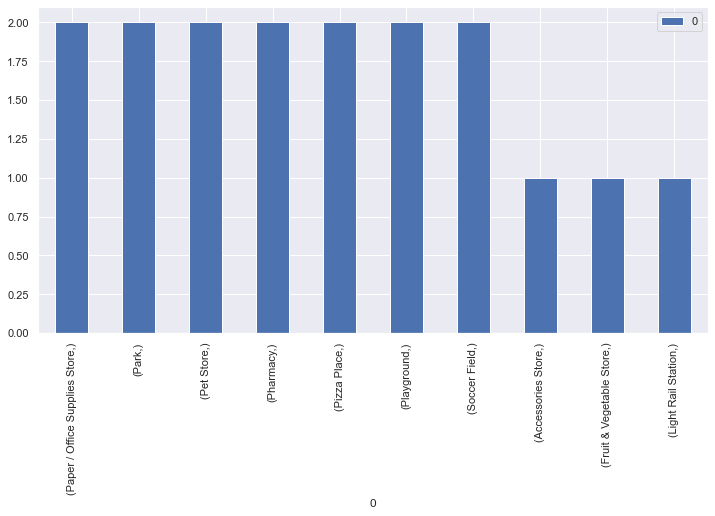

In [77]:
palavras_cluster4 = []
for index, row in dt_merged[dt_merged["Cluster Labels"]==4].iterrows():
    palavras_cluster4.append(row['1st Most Common Venue'])
    palavras_cluster4.append(row['2nd Most Common Venue'])
    palavras_cluster4.append(row["3rd Most Common Venue"])
    palavras_cluster4.append(row["4th Most Common Venue"])
    palavras_cluster4.append(row["5th Most Common Venue"])
    palavras_cluster4.append(row["6th Most Common Venue"])
    palavras_cluster4.append(row["7th Most Common Venue"])
    palavras_cluster4.append(row["8th Most Common Venue"])
    palavras_cluster4.append(row["9th Most Common Venue"])
    palavras_cluster4.append(row["10th Most Common Venue"])
    
df_venues_count_cluster4 = pd.DataFrame(palavras_cluster4)
df_venues_count_cluster4 = pd.DataFrame(df_venues_count_cluster4.value_counts())

top_10_venues_cluster4 = df_venues_count_cluster4.head(10)
top_10_venues_cluster4.plot(kind="bar", figsize=(12,6))

Cluster 5

<AxesSubplot:xlabel='0'>

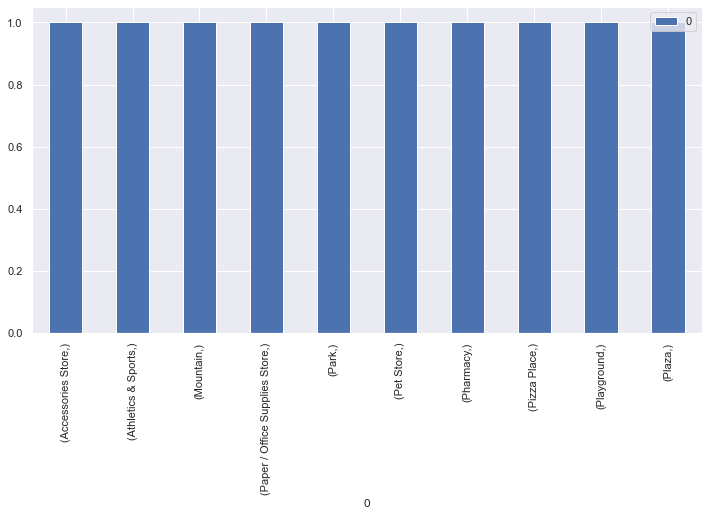

In [78]:
palavras_cluster5 = []
for index, row in dt_merged[dt_merged["Cluster Labels"]==5].iterrows():
    palavras_cluster5.append(row['1st Most Common Venue'])
    palavras_cluster5.append(row['2nd Most Common Venue'])
    palavras_cluster5.append(row["3rd Most Common Venue"])
    palavras_cluster5.append(row["4th Most Common Venue"])
    palavras_cluster5.append(row["5th Most Common Venue"])
    palavras_cluster5.append(row["6th Most Common Venue"])
    palavras_cluster5.append(row["7th Most Common Venue"])
    palavras_cluster5.append(row["8th Most Common Venue"])
    palavras_cluster5.append(row["9th Most Common Venue"])
    palavras_cluster5.append(row["10th Most Common Venue"])
    
df_venues_count_cluster5 = pd.DataFrame(palavras_cluster5)
df_venues_count_cluster5 = pd.DataFrame(df_venues_count_cluster5.value_counts())

top_10_venues_cluster5 = df_venues_count_cluster5.head(10)
top_10_venues_cluster5.plot(kind="bar", figsize=(12,6))

Cluster 6

<AxesSubplot:xlabel='0'>

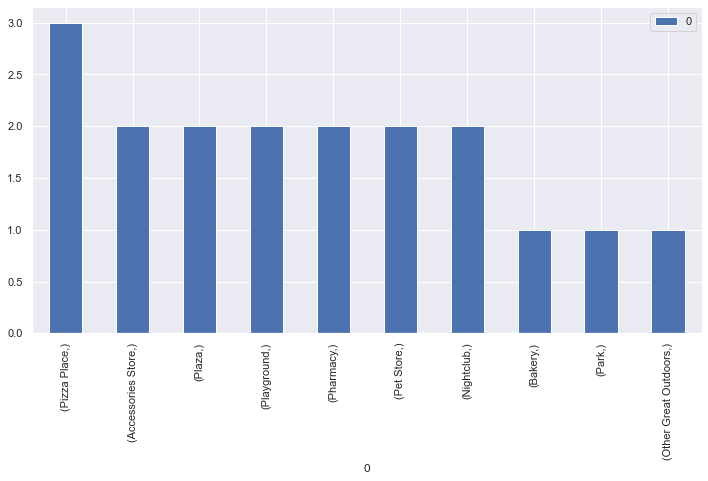

In [80]:
palavras_cluster6 = []
for index, row in dt_merged[dt_merged["Cluster Labels"]==6].iterrows():
    palavras_cluster6.append(row['1st Most Common Venue'])
    palavras_cluster6.append(row['2nd Most Common Venue'])
    palavras_cluster6.append(row["3rd Most Common Venue"])
    palavras_cluster6.append(row["4th Most Common Venue"])
    palavras_cluster6.append(row["5th Most Common Venue"])
    palavras_cluster6.append(row["6th Most Common Venue"])
    palavras_cluster6.append(row["7th Most Common Venue"])
    palavras_cluster6.append(row["8th Most Common Venue"])
    palavras_cluster6.append(row["9th Most Common Venue"])
    palavras_cluster6.append(row["10th Most Common Venue"])
    
df_venues_count_cluster6 = pd.DataFrame(palavras_cluster6)
df_venues_count_cluster6 = pd.DataFrame(df_venues_count_cluster6.value_counts())

top_10_venues_cluster6 = df_venues_count_cluster6.head(10)
top_10_venues_cluster6.plot(kind="bar", figsize=(12,6))

Cluster 7

<AxesSubplot:xlabel='0'>

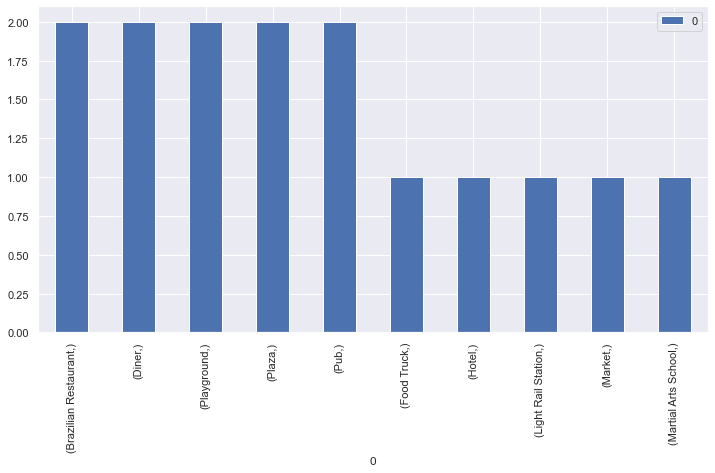

In [81]:
palavras_cluster7 = []
for index, row in dt_merged[dt_merged["Cluster Labels"]==7].iterrows():
    palavras_cluster7.append(row['1st Most Common Venue'])
    palavras_cluster7.append(row['2nd Most Common Venue'])
    palavras_cluster7.append(row["3rd Most Common Venue"])
    palavras_cluster7.append(row["4th Most Common Venue"])
    palavras_cluster7.append(row["5th Most Common Venue"])
    palavras_cluster7.append(row["6th Most Common Venue"])
    palavras_cluster7.append(row["7th Most Common Venue"])
    palavras_cluster7.append(row["8th Most Common Venue"])
    palavras_cluster7.append(row["9th Most Common Venue"])
    palavras_cluster7.append(row["10th Most Common Venue"])
    
df_venues_count_cluster7 = pd.DataFrame(palavras_cluster7)
df_venues_count_cluster7 = pd.DataFrame(df_venues_count_cluster7.value_counts())

top_10_venues_cluster7 = df_venues_count_cluster7.head(10)
top_10_venues_cluster7.plot(kind="bar", figsize=(12,6))

Cluster 8

<AxesSubplot:xlabel='0'>

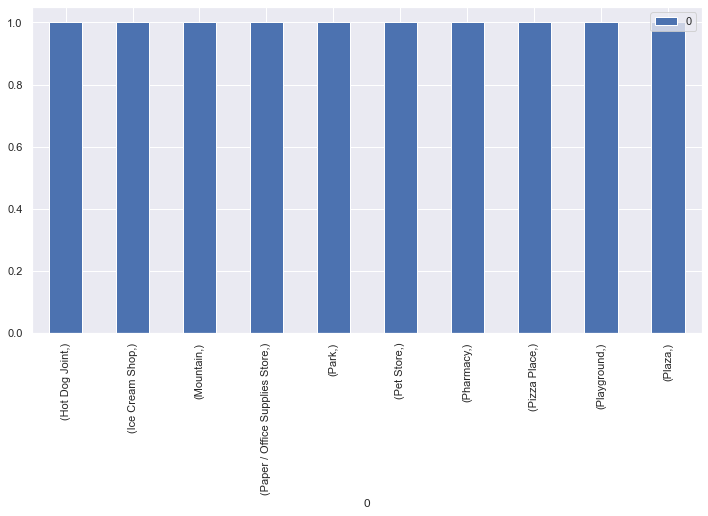

In [82]:
palavras_cluster8 = []
for index, row in dt_merged[dt_merged["Cluster Labels"]==8].iterrows():
    palavras_cluster8.append(row['1st Most Common Venue'])
    palavras_cluster8.append(row['2nd Most Common Venue'])
    palavras_cluster8.append(row["3rd Most Common Venue"])
    palavras_cluster8.append(row["4th Most Common Venue"])
    palavras_cluster8.append(row["5th Most Common Venue"])
    palavras_cluster8.append(row["6th Most Common Venue"])
    palavras_cluster8.append(row["7th Most Common Venue"])
    palavras_cluster8.append(row["8th Most Common Venue"])
    palavras_cluster8.append(row["9th Most Common Venue"])
    palavras_cluster8.append(row["10th Most Common Venue"])
    
df_venues_count_cluster8 = pd.DataFrame(palavras_cluster8)
df_venues_count_cluster8 = pd.DataFrame(df_venues_count_cluster8.value_counts())

top_10_venues_cluster8 = df_venues_count_cluster8.head(10)
top_10_venues_cluster8.plot(kind="bar", figsize=(12,6))

Cluster 9

<AxesSubplot:xlabel='0'>

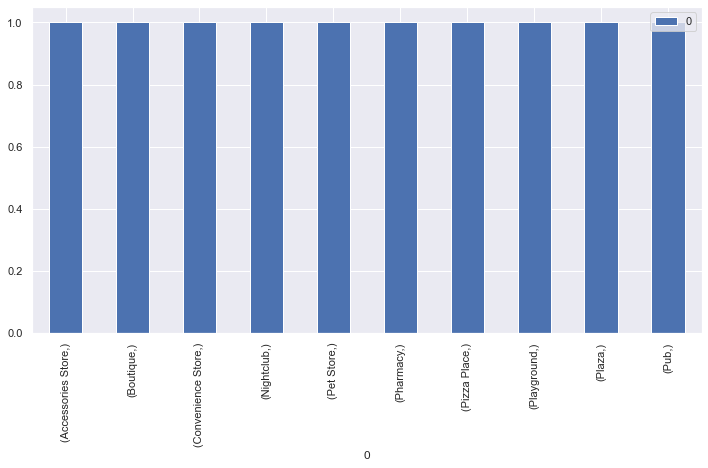

In [83]:
palavras_cluster9 = []
for index, row in dt_merged[dt_merged["Cluster Labels"]==9].iterrows():
    palavras_cluster9.append(row['1st Most Common Venue'])
    palavras_cluster9.append(row['2nd Most Common Venue'])
    palavras_cluster9.append(row["3rd Most Common Venue"])
    palavras_cluster9.append(row["4th Most Common Venue"])
    palavras_cluster9.append(row["5th Most Common Venue"])
    palavras_cluster9.append(row["6th Most Common Venue"])
    palavras_cluster9.append(row["7th Most Common Venue"])
    palavras_cluster9.append(row["8th Most Common Venue"])
    palavras_cluster9.append(row["9th Most Common Venue"])
    palavras_cluster9.append(row["10th Most Common Venue"])
    
df_venues_count_cluster9 = pd.DataFrame(palavras_cluster9)
df_venues_count_cluster9 = pd.DataFrame(df_venues_count_cluster9.value_counts())

top_10_venues_cluster9 = df_venues_count_cluster9.head(10)
top_10_venues_cluster9.plot(kind="bar", figsize=(12,6))

Cluster 10

<AxesSubplot:xlabel='0'>

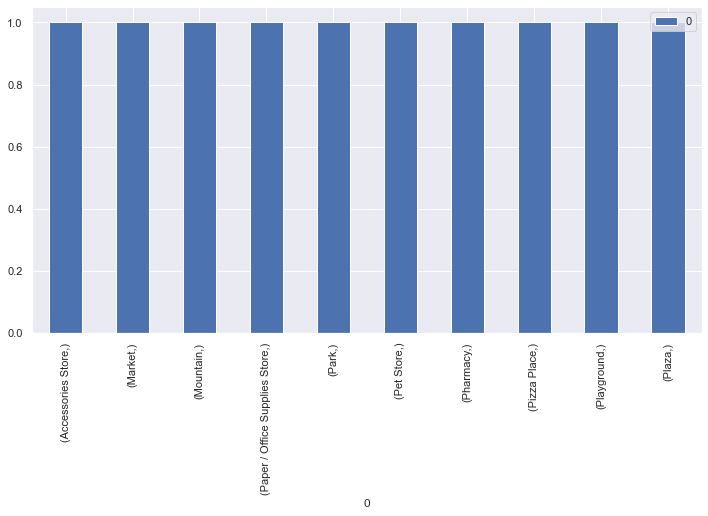

In [84]:
palavras_cluster10 = []
for index, row in dt_merged[dt_merged["Cluster Labels"]==10].iterrows():
    palavras_cluster10.append(row['1st Most Common Venue'])
    palavras_cluster10.append(row['2nd Most Common Venue'])
    palavras_cluster10.append(row["3rd Most Common Venue"])
    palavras_cluster10.append(row["4th Most Common Venue"])
    palavras_cluster10.append(row["5th Most Common Venue"])
    palavras_cluster10.append(row["6th Most Common Venue"])
    palavras_cluster10.append(row["7th Most Common Venue"])
    palavras_cluster10.append(row["8th Most Common Venue"])
    palavras_cluster10.append(row["9th Most Common Venue"])
    palavras_cluster10.append(row["10th Most Common Venue"])
    
df_venues_count_cluster10 = pd.DataFrame(palavras_cluster10)
df_venues_count_cluster10 = pd.DataFrame(df_venues_count_cluster10.value_counts())

top_10_venues_cluster10 = df_venues_count_cluster10.head(10)
top_10_venues_cluster10.plot(kind="bar", figsize=(12,6))

Cluster 11

<AxesSubplot:xlabel='0'>

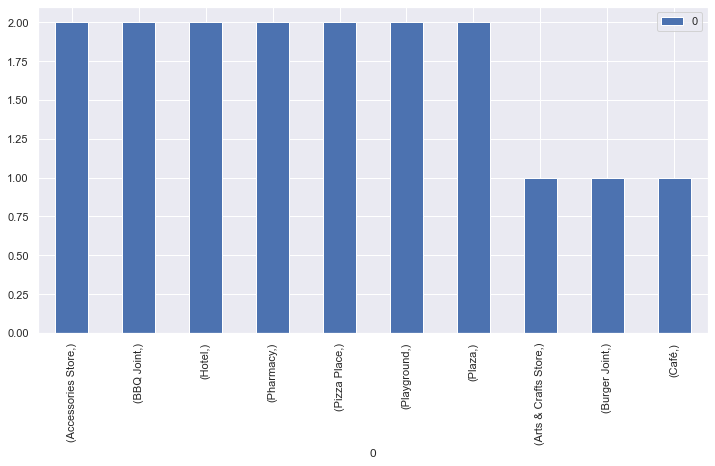

In [85]:
palavras_cluster11 = []
for index, row in dt_merged[dt_merged["Cluster Labels"]==11].iterrows():
    palavras_cluster11.append(row['1st Most Common Venue'])
    palavras_cluster11.append(row['2nd Most Common Venue'])
    palavras_cluster11.append(row["3rd Most Common Venue"])
    palavras_cluster11.append(row["4th Most Common Venue"])
    palavras_cluster11.append(row["5th Most Common Venue"])
    palavras_cluster11.append(row["6th Most Common Venue"])
    palavras_cluster11.append(row["7th Most Common Venue"])
    palavras_cluster11.append(row["8th Most Common Venue"])
    palavras_cluster11.append(row["9th Most Common Venue"])
    palavras_cluster11.append(row["10th Most Common Venue"])
    
df_venues_count_cluster11 = pd.DataFrame(palavras_cluster11)
df_venues_count_cluster11 = pd.DataFrame(df_venues_count_cluster11.value_counts())

top_10_venues_cluster11 = df_venues_count_cluster11.head(10)
top_10_venues_cluster11.plot(kind="bar", figsize=(12,6))